In [75]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

# [3월 14일]
---

## # 회귀 트리
- 회귀 함수를 기반으로 하지 않고 결정 트리와 같이 트리를 기반으로 하는 회귀 방식
- 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측
- 리프 노드에서 예측 결정 값을 만드는 과정에서 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산
- 결정트리, 랜덤 포레스트, GBM, XGBOOST, LIGHTGBM 등 트리 기반의 알고리즘은 분류뿐만 아니라 회귀도 가능한데 트리 생성이 CART(Classification And Regression Trees)에 기반하고 있기 때문이며 CART는 분류뿐만 아니라 회귀도 가능하게 해주는 트리 생성 알고리즘이다.

In [22]:
boston = load_boston()

boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df['PRICE'] = boston.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [39]:
X = boston_df.iloc[:, :-1]
y = boston_df.iloc[:, -1]

kfold = KFold(n_splits = 5, shuffle = True)

rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000, n_jobs = -1)
neg_mse_scores = cross_val_score(rf_reg, X, y, scoring = 'neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('개별 mse : ', np.round(-1 * neg_mse_scores, 3))
print('개별 rmse : ', np.round(rmse_scores, 3))
print('평균 rmse : ', np.round(avg_rmse, 3))

개별 mse :  [ 7.883 13.143 20.574 46.226 18.878]
개별 rmse :  [2.808 3.625 4.536 6.799 4.345]
평균 mse :  4.423


In [61]:
# 교차검증 사용자 함수 작성하고 XGBRegressor 객체를 사용하여 모델링 및 평가

def get_eval(model, X_train, y_train):
    print('*****', model, '*****')
    if model == 'XGBRegressor': 
        model = XGBRegressor(random_state = 0, n_estimators = 1000, learning_rate = 0.1, max_depth = 3, tree_method ='gpu_hist', gpu_id=0, n_jobs = -1)
    elif model == 'LGBMRegressor':
        model = LGBMRegressor(random_state = 0, n_estimators = 1000, max_depth = 128, min_child_samples = 100, num_leaves = 32, n_jobs = -1)
    elif model == 'DecisionTreeRegressor':
        model = DecisionTreeRegressor(random_state = 0, max_depth = 4)
    neg_mse_scores = cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = KFold(n_splits = 5, shuffle = True))
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('개별 mse : ', np.round(-1 * neg_mse_scores, 3))
    print('개별 rmse : ', np.round(rmse_scores, 3))
    print('평균 rmse : ', np.round(avg_rmse, 3))
       
        
for i in ['XGBRegressor', 'LGBMRegressor', 'DecisionTreeRegressor']:
    get_eval(i, X, y)
    print()

***** XGBRegressor *****
개별 mse :  [12.592  7.005 11.155 16.423  8.043]
개별 rmse :  [3.549 2.647 3.34  4.053 2.836]
평균 rmse :  3.285

***** LGBMRegressor *****
개별 mse :  [21.718 38.003 18.116 19.936 14.507]
개별 rmse :  [4.66  6.165 4.256 4.465 3.809]
평균 rmse :  4.671

***** DecisionTreeRegressor *****
개별 mse :  [17.082 38.628 10.506 25.099 24.021]
개별 rmse :  [4.133 6.215 3.241 5.01  4.901]
평균 rmse :  4.7



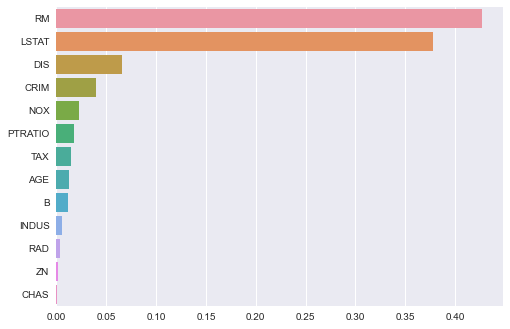

In [74]:
# 독립변수 중요도 시각화

rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000, n_jobs = -1)
rf_reg.fit(X, y)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X.columns)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series, y = feature_series.index)
plt.show()

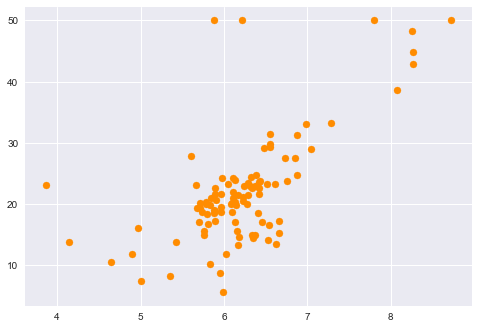

In [73]:
boston_sample = boston_df[['RM', 'PRICE']]
boston_sample = boston_sample.sample(n = 100, random_state = 0)
plt.figure()
plt.scatter(boston_sample.RM, boston_sample.PRICE, c = 'darkorange')

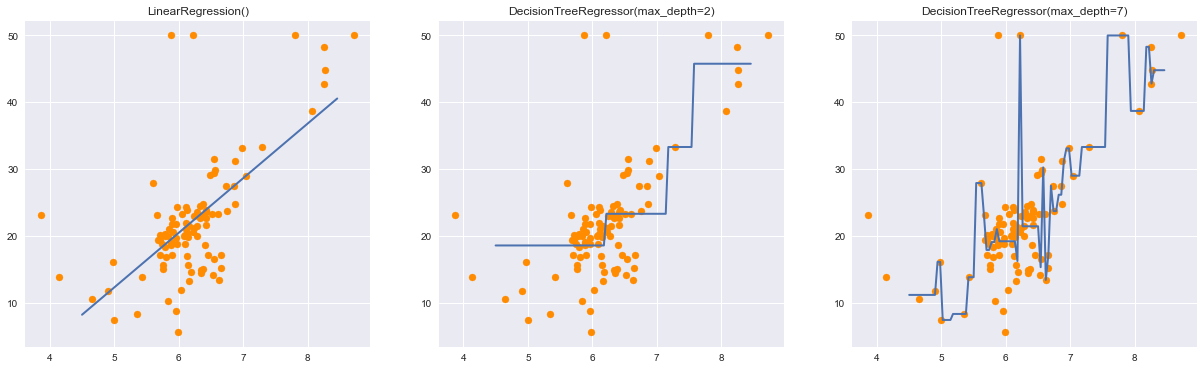

In [93]:
lr_reg = LinearRegression()
dt_reg2 = DecisionTreeRegressor(max_depth = 2)
dt_reg7 = DecisionTreeRegressor(max_depth = 7)

# 테스트용 데이터 셋 : 4.5 ~ 8.5
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

X_feature = boston_sample['RM'].values.reshape(-1, 1)
y_target = boston_sample['PRICE'].values.reshape(-1, 1)

models = [lr_reg, dt_reg2, dt_reg7]
fig = plt.figure(figsize = (21, 6))
for i, model in enumerate(models):
    model.fit(X_feature, y_target)
    pred = model.predict(X_test)
    ax = f'ax{i+1}'
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title(model)
    ax.scatter(boston_sample['RM'], boston_sample['PRICE'], c = 'darkorange')
    ax.plot(X_test, pred, label = model, linewidth = 2)
plt.show()